Steve ENYEGUE
### Granger causality for cryptocurrencies

In [21]:
import yfinance as yf
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use("ggplot")
from sklearn.cluster import KMeans

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic


Indeed, if one variable caused another variable, then necessarily the two variables must be correlated. Conversely, it is not enough that two variables are correlated, for it to have causality (correlation is not causation)

In [22]:
tickers = ['BTC-USD','XRP-USD','XMR-USD','ETH-USD']

df = yf.download(tickers, start="2019-01-01", end="2021-01-01")['Adj Close']

daily_returns = df.pct_change().dropna()

print(daily_returns.shape) 
daily_returns.tail()


[*********************100%***********************]  4 of 4 completed
(727, 4)


,BTC-USD,ETH-USD,XMR-USD,XRP-USD
Date,,,,
2020-12-27,-0.006231,0.073614,-0.063602,-0.039611
2020-12-28,0.030927,0.069956,0.058686,-0.123944
2020-12-29,0.010250,0.001537,-0.030596,-0.108873
2020-12-30,0.054034,0.027475,-0.012520,-0.041337
2020-12-31,0.005574,-0.018381,-0.017570,0.037851


In [26]:
corr_matrix = daily_returns.corr()
corr_matrix.style.background_gradient(cmap='coolwarm')

,BTC-USD,ETH-USD,XMR-USD,XRP-USD
BTC-USD,1.000000,0.829491,0.772489,0.593272
ETH-USD,0.829491,1.000000,0.781427,0.705639
XMR-USD,0.772489,0.781427,1.000000,0.610136
XRP-USD,0.593272,0.705639,0.610136,1.000000


All assets are correlated.


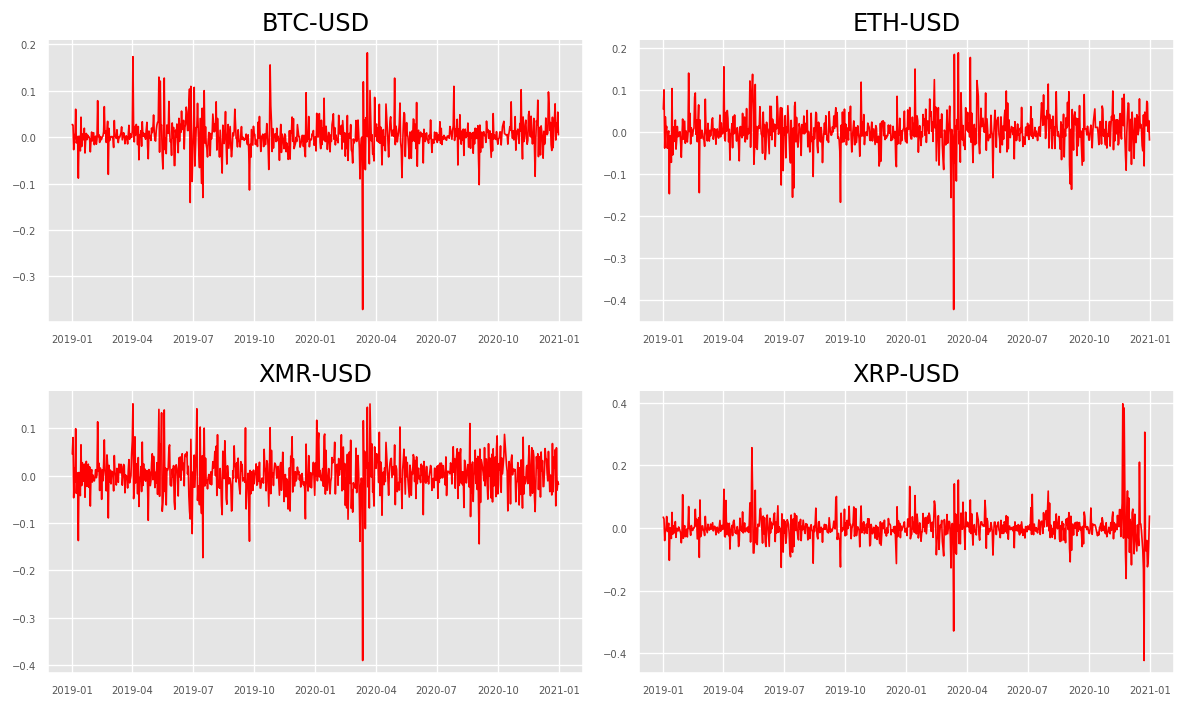

In [28]:
# Plot
fig, axes = plt.subplots(nrows=2, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = daily_returns[daily_returns.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(daily_returns.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

We can see uptrends (non-stationarity).
We have to
regress non-stationary variables.
We do not have any false regression when the variables xt and yt are cointegrated
(I didn't have time to verify this criteria)

Each of the series have a fairly similar trend patterns over the years.

Alright, next step in the analysis is to check for causality amongst these series. The Granger’s Causality test and the Cointegration test can help us with that.

In [25]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(daily_returns, variables = daily_returns.columns)  

,BTC-USD_x,ETH-USD_x,XMR-USD_x,XRP-USD_x
BTC-USD_y,1.0000,0.0023,0.0067,0.0157
ETH-USD_y,0.0152,1.0000,0.0291,0.1814
XMR-USD_y,0.3745,0.0887,1.0000,0.0731
XRP-USD_y,0.0043,0.0164,0.0108,1.0000


If a given p-value is > significance level (0.05), then, the corresponding X series (column) causes the Y (row).

- Bitcoin's daily returns are caused by none of the crypto listed
- Ethereum's daily returns are caused by Ripple
- Monero's daily returns are caused by Bitcoin, Ethereum, Ripple
- Ripple's daily returned are caused by none of the crypto listed